In [1]:
import tensorflow as tf

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import lmdb
import pickle

import util

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path[0]

'C:\\Users\\Joshua\\classes\\cs231n\\chow\\trainer'

### Explore Image Directory

In [5]:
# Set local data directory
import pathlib
# data_dir = pathlib.Path('../data/local_subset')
data_dir = pathlib.Path(sys.path[0]).parents[0] / "data" / "local_subset" 
print(data_dir)

C:\Users\Joshua\classes\cs231n\chow\data\local_subset


Check dir containing data subset exists True
Count the number of images 29


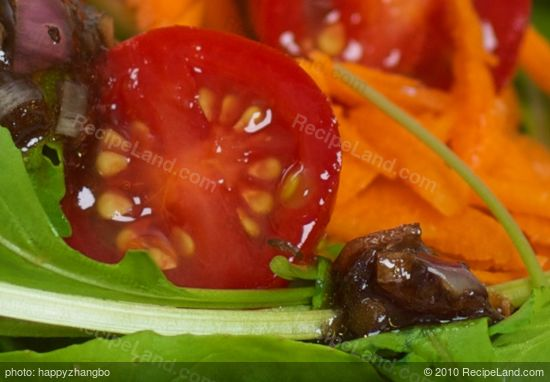

In [6]:
# Navigate to last set of subdirectories
path000 = data_dir.joinpath('0/0/0')
print("Check dir containing data subset exists", path000.exists())

image_count = len(list(path000.rglob('*.jpg')))
print("Count the number of images", image_count)

# Display examples
examples = list(path000.rglob('*.jpg'))
for image_path in examples[:1]:
    display.display(Image.open(str(image_path)))

### Load Dataset from LMDB and Images Directory

In [7]:
# Store all image path
list_ds_all = tf.data.Dataset.list_files(str(path000/'*/*'))
print(path000/'*/*')
for f in list_ds_all.take(5):
  print(f.numpy())

C:\Users\Joshua\classes\cs231n\chow\data\local_subset\0\0\0\*\*
b'C:\\Users\\Joshua\\classes\\cs231n\\chow\\data\\local_subset\\0\\0\\0\\0\\00004988eb.jpg'
b'C:\\Users\\Joshua\\classes\\cs231n\\chow\\data\\local_subset\\0\\0\\0\\f\\000fbbf442.jpg'
b'C:\\Users\\Joshua\\classes\\cs231n\\chow\\data\\local_subset\\0\\0\\0\\b\\000b053df5.jpg'
b'C:\\Users\\Joshua\\classes\\cs231n\\chow\\data\\local_subset\\0\\0\\0\\f\\000fb7635c.jpg'
b'C:\\Users\\Joshua\\classes\\cs231n\\chow\\data\\local_subset\\0\\0\\0\\b\\000bc15cab.jpg'


In [8]:
# Extract labels out of LMDB and store in dict by image id
# data_dict = get_labels_dict('..\data\val_lmdb') # this directory must contain .mdb and .lock files
# pickle.dump(data_dict, open( "data_dict_val.pkl", "wb" ) )
data_dict = pickle.load(open('../data/data_dict_val.pkl', 'rb'))
print(list(data_dict)[:5])

['05ef2f41f8.jpg', '6c98ae689b.jpg', '586f8545d5.jpg', '665bbeafc7.jpg', '87aea5035b.jpg']


In [9]:
# Some images do not have a mapping in the data dict ...
prefix000 = [img_id for img_id in list(data_dict) if img_id[:3] == '000']
num_unlabeled = 0
for f in list_ds_all:
    foo = str(f.numpy()).split('\\')[-1][:-1] # last slice excludes ' at end of img name
    if foo not in prefix000:
        num_unlabeled += 1
print("Percent images without data_dict label: ", num_unlabeled / len(list(list_ds_all)))

Percent images without data_dict label:  0.1724137931034483


In [86]:
# TODO: One hot encode ingrs, then store into tf ds (don't pad)

# Build a lookup table for each of the 3 types of labels
def build_tf_hash_table(label_name):
    # choose data dict column by label name
    if label_name == 'ingrs':
        label_col = 0
    elif label_name == 'classes':
        label_col = 1
    elif label_name == 'intrs':
        label_col = 2
    else:
        print("ERROR: invalid label name passed")
        return
    
    img_ids = np.asarray(list(data_dict.keys()))
    labels = np.asarray(list(data_dict.values()))[:,label_col]
    
    # one hot encode
    if label_name == 'ingrs':
        labels = encode_ingr_ids(labels, ingr2id, recipe_id2vocab)
    elif label_name == 'classes':
        labels = encode_class_ids(labels, class_vocab)
    
    # convert np arrays to tensors
    img_ids = tf.constant(img_ids)
    labels = tf.constant(labels, dtype=tf.float32)
    
    # store into tensorflow lookup table
    table = tf.lookup.StaticHashTable(
        initializer=tf.lookup.KeyValueTensorInitializer(
            keys=img_ids,
            values=labels,
        ),
        default_value=tf.constant(np.repeat(-1, 3478).reshape(-1), dtype=tf.float32),
        name='labels_table'
    )
    return table

classes_table = build_tf_hash_table('ingrs')

ValueError: Shapes (3478,) and () are not compatible

In [84]:
tf.constant(np.repeat(-1, 3478).reshape(-1,1), dtype=tf.float32)

<tf.Tensor: shape=(3478, 1), dtype=float32, numpy=
array([[-1.],
       [-1.],
       [-1.],
       ...,
       [-1.],
       [-1.],
       [-1.]], dtype=float32)>

In [13]:
# Apply filtering to exclude unlabeled images
def check_labeled(img_path):
    img_id = tf.strings.split(img_path, os.path.sep)[-1]
    out = table.lookup(img_id)
    return out >= 0

list_ds = list_ds_all.filter(check_labeled)
print("Number of images in list_ds ...")
print("  originally (scraped from directories): ", len(list(list_ds_all)))
print("  after filtering out unlabeled: ", len(list(list_ds)))

Number of images in list_ds ...
  originally (scraped from directories):  29
  after filtering out unlabeled:  24


In [29]:
# Enable multiple images to process in parallel
labeled_ds = list_ds.map(lambda x: util.process_path(x, table), num_parallel_calls=AUTOTUNE) 

In [30]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    print(image.numpy())

Image shape:  (384, 512, 3)
Label:  8.0
[[[0.6        0.6509804  0.82745105]
  [0.6        0.6509804  0.82745105]
  [0.6        0.6509804  0.82745105]
  ...
  [0.5529412  0.5686275  0.6666667 ]
  [0.5411765  0.56078434 0.6745098 ]
  [0.54901963 0.5686275  0.68235296]]

 [[0.5921569  0.6431373  0.8196079 ]
  [0.5921569  0.6431373  0.8196079 ]
  [0.5882353  0.6392157  0.81568635]
  ...
  [0.5686275  0.5882353  0.6745098 ]
  [0.5882353  0.6039216  0.7019608 ]
  [0.5882353  0.6039216  0.70980394]]

 [[0.58431375 0.63529414 0.8117648 ]
  [0.5803922  0.6313726  0.8078432 ]
  [0.5764706  0.627451   0.80392164]
  ...
  [0.5568628  0.56078434 0.6392157 ]
  [0.5803922  0.58431375 0.6666667 ]
  [0.5764706  0.58431375 0.6666667 ]]

 ...

 [[0.67058825 0.30980393 0.05490196]
  [0.6784314  0.32941177 0.07058824]
  [0.68235296 0.32941177 0.08235294]
  ...
  [0.7568628  0.49803925 0.25882354]
  [0.7686275  0.5137255  0.2627451 ]
  [0.7843138  0.5372549  0.27450982]]

 [[0.65882355 0.3137255  0.0352941

### Prepare Dataset for Training

In [31]:
# Shuffle data and pre-batch so its available ASAP during training
BATCH_SIZE=25
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache) # for dataset too big for memory, caches preprocessing to `cache` filepath
        else:
            ds = ds.cache() # for small datasets, keeps it in memory

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat() # repeat forever
    ds = ds.padded_batch(BATCH_SIZE, ([None, None, 3],())) # to handle different image sizes
    ds = ds.prefetch(buffer_size=AUTOTUNE) # fetches next batch in background while model training

    return ds

train_ds = prepare_for_training(labeled_ds)

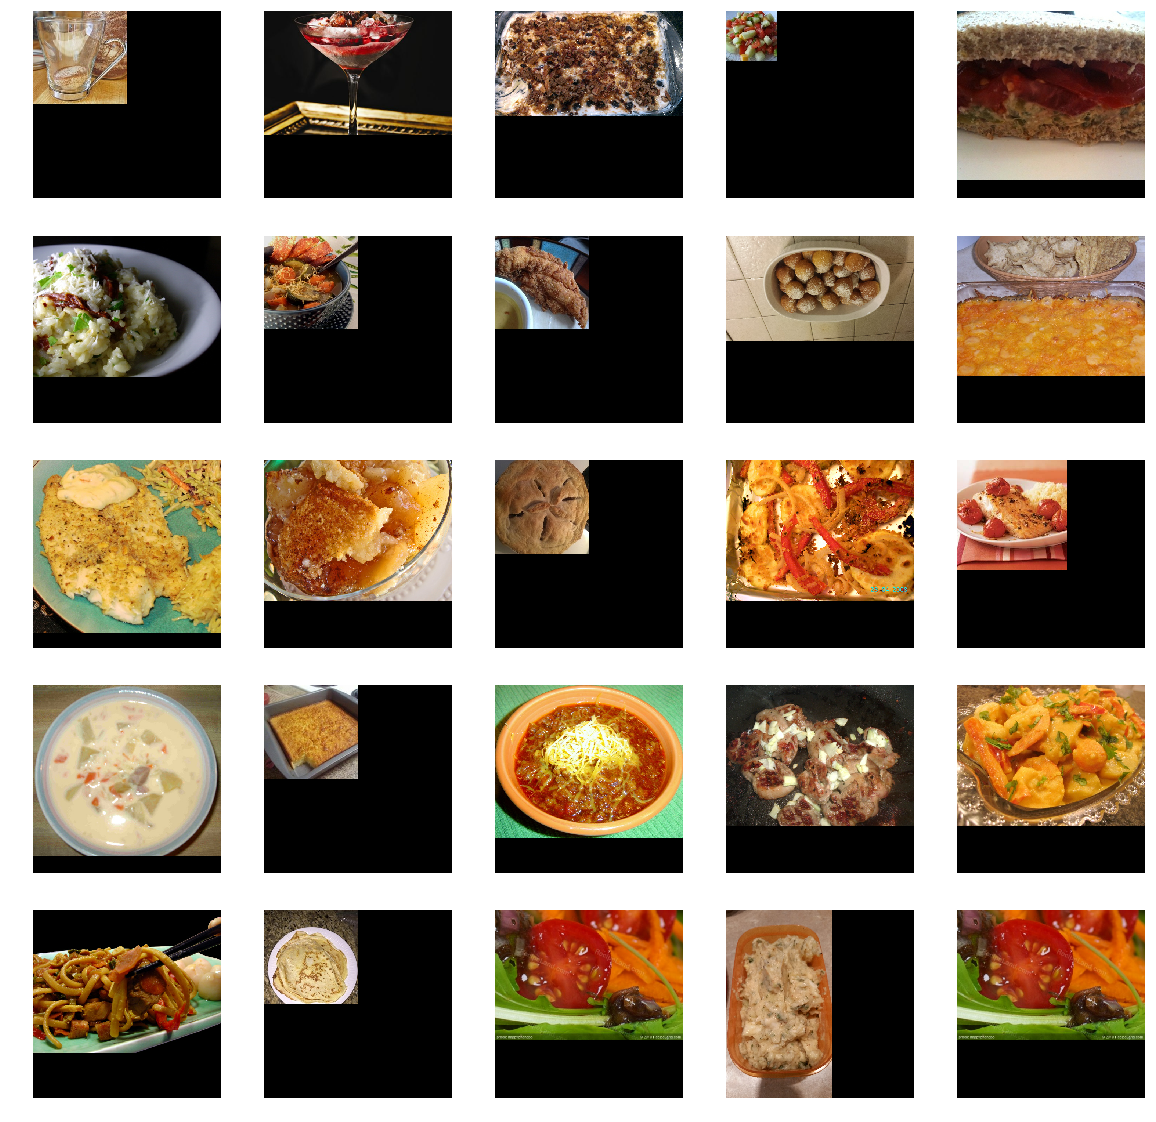

In [32]:
# Inspect batch images, especially for padding results
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20,20))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        # TODO: create get_label_names function for category + ingredients
        # plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

show_batch(image_batch.numpy(), label_batch.numpy())

### Caching Performance
More tricks [Input Pipeline Performance](../../guide/performance/datasets).

In [18]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [19]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds, steps=5)

.
5 batches: 63.262945890426636 s
1.97588 Images/s


In [20]:
filecache_ds = prepare_for_training(labeled_ds, cache="./recipe1m.tfcache")
timeit(filecache_ds, steps=5)

.
5 batches: 37.411669969558716 s
3.34120 Images/s


### Vocab Dict for Ingredients

In [11]:
# Vocab dict for all ingredients
vocab_path = '../data/vocab.txt' # downloaded from Im2Recipe repo
with open(vocab_path) as f_vocab:
    recipe_id2vocab = {i+2: w.rstrip() for i, w in enumerate(f_vocab)}
    recipe_id2vocab[1] = '</i>'

recipe_vocab2id = {v:k for k,v in recipe_id2vocab.items()}

# Check sample ingredient ids makes sense
example_ingr_ids = [5149,  382, 5399, 22785, 1]
example_ingr_vocab = ['flour_tortillas', 'marinade', 'asparagus_spears', 'sweetened_flaked_coconut', '</i>']

for ingr_id in example_ingr_ids:
    print(recipe_id2vocab[ingr_id])
for vocab in example_ingr_vocab:
    print(recipe_vocab2id[vocab])

flour_tortillas
marinade
asparagus_spears
sweetened_flaked_coconut
</i>
5149
382
5399
22785
1


In [41]:
from collections import defaultdict
# Ingredients label prep for one-hot encoding
# get set of unique ingredients
def get_unique_ingrs(data_dict):
    ingrs_set = set()
    for ingrs_vec, _, _ in data_dict.values(): # ingrs stored in first column
        stop = np.where(ingrs_vec == 1)[0][0] # 1 is end token
        ingrs_set.update(ingrs_vec[:stop])
    return np.array(list(ingrs_set))

val_ingrs = get_unique_ingrs(data_dict) # TODO val_data_dict instead of generic `data_dict`
# TODO test_ingrs = get_unique_ingrs(test_data_dict)
test_ingrs = []
all_ingrs = np.hstack((val_ingrs, test_ingrs))
all_ingrs = np.array(list(set(all_ingrs)), dtype=np.int32)

# examine ingredients, manually compiling vocab to ignore (artifacts from recipe1m scraping method)
print("Example ingr elements: ", [recipe_id2vocab[ingr_id] for ingr_id in all_ingrs[1000:1040]])
print("Number of unique ingrs before ignoring:", len(all_ingrs))
# print("All ingredients: ", sorted([ingr_vocab[ingr_id] for ingr_id in all_ingrs]))
ignored_ingrs = ['Ingredients', '1', '100', '2', '200', '23', '30', '300', \
                '4', '450', '50', '500', '6', '600']
ignored_ingr_ids = [recipe_vocab2id[word] for word in ignored_ingrs]

# assign new ids and get new id <> vocab dictionaries
def get_ingr_vocab(recipe_id2vocab, all_ingrs, ignored_ingr_ids):
    """Assigns new consecutive ids to ingredients-only condensed vocab and
    returns ingredient <> id dicts
    Args: 
    - dict of all recipe vocab
    - list of all unique ingr ids
    - list of ignored ingr ids
    Return:
    - id to ingredient dict (for data preprocessing) 
    - ingredient to id dict (for model analysis)
    """
    # map ignored ingredients to -1 to indicate exclusion in final dataset
    id2ingr = defaultdict(lambda: -1)
    ingr2id = defaultdict(lambda: -1)
    all_ingrs_clean = set(all_ingrs)
    for ingr_id in ignored_ingr_ids:
        all_ingrs_clean.discard(ingr_id)
    all_ingrs_clean = np.array(list(all_ingrs_clean))
    
    # build both dictionaries
    for new_id, curr_id in enumerate(all_ingrs_clean): # enumerate generates new ids for ingr vocab
        ingr_word = recipe_id2vocab[curr_id]
        id2ingr[new_id] = ingr_word
        ingr2id[ingr_word] = new_id
    
    return ingr2id, id2ingr 

ingr2id, id2ingr = get_ingr_vocab(recipe_id2vocab, all_ingrs, ignored_ingr_ids)
print("Number of unique ingrs after ignoring:", len(list(ingr2id)))

def encode_ingr_ids(curr_ingr_labels, ingr2id, recipe_id2vocab):
    """One hot encodes ingredient labels from Recipe1M lmdb and
    returns a rectangular array of encoded arrays"""
    # initialize one-hot encoded vectors
    num_ingrs = len(list(ingr2id))
    num_samples = curr_ingr_labels.shape[0]
    new_ingr_labels = np.zeros((num_samples, num_ingrs))
    
    # fill vectors sample by sample
    for idx, label in enumerate(curr_ingr_labels):
        # iterate thru label vector until stop token
        for curr_id in label:
            if curr_id == 1: # stop token
                break
            word = recipe_id2vocab[curr_id]
            new_id = ingr2id[word]
            if new_id < 0: # check if invalid id, i.e. -1
                pass
            new_ingr_labels[idx][new_id] = 1
    return new_ingr_labels 

Example ingr elements:  ['Minute_Rice', 'cornbread', 'ditalini', 'round_steak', 'gnocchi', 'white_chocolate', 'melon', 'fudge', 'advocaat', 'chutney', '100', 'giardiniera', 'black_beans', 'star_fruit', 'schmaltz', 'satay_sauce', 'chestnuts', 'kirschwasser', 'watercress', 'seafood_sauce', 'fresh_cranberries', 'turkey_stock', 'pork_liver', 'soy_yogurt', 'okra', 'sesame_seed_oil', 'grits', 'chicken_breasts', 'Dressing', 'bechamel_sauce', 'espresso', 'pumpkin_pie_mix', 'pork_fat', 'pistachio_paste', 'creme_fraiche', 'dried_currants', 'grape_jelly', 'pea_tendrils', 'pepperoni', 'glace_cherries']
Number of unique ingrs before ignoring: 3478
Number of unique ingrs after ignoring: 3464


In [54]:
curr_ingr_labels = np.asarray(list(data_dict.values()))[:,0]
one_hot_ingr_labels = encode_ingr_ids(curr_ingr_labels, ingr2id, recipe_id2vocab)

In [55]:
from collections import Counter
print("Total number of images: ", one_hot_ingr_labels.shape[0])
print("Image count by number of ingredients:")
hist_num_ingrs = Counter(np.sum(one_hot_ingr_labels, axis=1))
for key in sorted(hist_num_ingrs.keys()):
    print(key, ":", hist_num_ingrs[key])
    
# TODO: reduce noise by removing all images with < 4 ingredients

Total number of images:  82093
Image count by number of ingredients:
0.0 : 167
1.0 : 815
2.0 : 2534
3.0 : 4537
4.0 : 6653
5.0 : 8616
6.0 : 9356
7.0 : 9573
8.0 : 9209
9.0 : 8082
10.0 : 6809
11.0 : 4910
12.0 : 3852
13.0 : 2653
14.0 : 1686
15.0 : 1125
16.0 : 728
17.0 : 471
18.0 : 317


### Vocab Dict for Food Classes

In [13]:
# Vocab dict for food classes
class_path = '../data/classes1M.pkl' # stores 2 dictionaries, but we just need the 2nd
with open(class_path,'rb') as f:
    img_class_dict = pickle.load(f) # class_id: img_id 
                                # (most class_ids are 0, i.e. uncategorized background)
    class_vocab = pickle.load(f) # 21 : white chocolate (1048 classes)

def get_class(class_id):
    return class_vocab[class_id]
get_class(54)

'chicken rice'

In [61]:
def encode_class_ids(curr_class_labels, class_vocab):
    """One hot encodes food class ids from Recipe1M lmdb and
    returns a rectangular array of encoded arrays"""
    # initialize one-hot encoded vectors
    num_classes = len(list(class_vocab))
    num_samples = curr_class_labels.shape[0]
    new_class_labels = np.zeros((num_samples, num_classes))
    
    # fill vectors sample by sample
    for idx, curr_id in enumerate(curr_class_labels):
        new_class_labels[idx][curr_id-1] = 1 # 0-indexing the 1-indexed class ids
    return new_class_labels 

In [62]:
curr_class_labels = np.asarray(list(data_dict.values()))[:,1]
one_hot_class_labels = encode_class_ids(curr_class_labels, class_vocab)

In [65]:
print("Total number of images: ", one_hot_class_labels.shape[0])
print("Image count by class:")
hist_num_classes = Counter(curr_class_labels)
for key in sorted(hist_num_classes.keys()):
    print(key, ":", hist_num_classes[key])

Total number of images:  82093
Image count by class:
1 : 39876
2 : 893
3 : 330
4 : 747
5 : 554
6 : 580
7 : 509
8 : 417
9 : 388
10 : 315
11 : 269
12 : 276
13 : 228
14 : 273
15 : 39
16 : 324
17 : 29
18 : 197
19 : 234
20 : 172
21 : 211
22 : 184
23 : 175
24 : 16
25 : 150
26 : 183
27 : 169
28 : 221
29 : 191
30 : 5
31 : 125
32 : 249
33 : 172
34 : 170
35 : 176
36 : 106
37 : 211
38 : 65
39 : 197
40 : 11
41 : 77
42 : 128
43 : 85
44 : 17
45 : 157
46 : 106
47 : 143
48 : 9
49 : 133
50 : 76
51 : 106
52 : 135
53 : 71
54 : 144
55 : 24
56 : 109
57 : 67
58 : 82
59 : 96
60 : 160
61 : 94
62 : 86
63 : 192
64 : 114
65 : 150
66 : 169
67 : 21
68 : 9
69 : 113
70 : 107
71 : 110
72 : 64
73 : 84
74 : 81
75 : 86
76 : 100
77 : 93
78 : 66
79 : 163
80 : 66
81 : 79
82 : 82
83 : 9
84 : 93
85 : 83
86 : 153
87 : 144
88 : 55
89 : 86
90 : 112
91 : 113
92 : 89
93 : 38
94 : 103
95 : 74
96 : 105
97 : 58
98 : 180
99 : 15
100 : 84
101 : 37
102 : 69
103 : 91
104 : 62
105 : 118
106 : 53
107 : 33
108 : 79
109 : 78
110 : 87
111 : 